In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta, datetime
import numpy as np
from scipy import stats
import math
import re
import random

In [144]:
all_stunts = pd.read_csv('/kaggle/input/all-stunts/final_stunts.csv')
games = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/games.csv')
games = games[['gameId','homeTeamAbbr','visitorTeamAbbr']]
all_stunts = all_stunts.merge(games,on='gameId',how = 'left')
all_stunts['yardsToEZ'] = all_stunts.absoluteYardlineNumber - 10
all_stunts['pointDifferential'] = np.where(all_stunts.possessionTeam == all_stunts.homeTeamAbbr,
                                   all_stunts.preSnapVisitorScore - all_stunts.preSnapHomeScore,
                                   all_stunts.preSnapHomeScore - all_stunts.preSnapVisitorScore)
all_stunts['min_sec'] = all_stunts.gameClock.map(lambda x:x.split(':'))
all_stunts['quarterTimeLeft'] = all_stunts.min_sec.map(lambda x:(int(x[0])*60)+int(x[1]))
all_stunts['gameTimeLeft'] = (4 - all_stunts.quarter)*15*60 + all_stunts.quarterTimeLeft
all_stunts = all_stunts.rename(columns = {"('blitz', 'mean')":"blitz",
                             "('blitz_class', '')":"blitz_class",
                             "('stunt', '')":"stunt",
                             "('stunt_class', '')":"stunt_class",
                             "('4manfront', '')":"fourManFront",
                             "('npos_list', '')":"npos_list"})
# all_stunts = all_stunts.drop(all_stunts.index[0])
all_stunts['gameId'] = all_stunts.gameId.astype('int64')
all_stunts['playId'] = all_stunts.playId.astype('int64')
all_stunts = all_stunts.drop(['Unnamed: 0'], axis = 1)
all_stunts = all_stunts.dropna(subset = ['yardsToEZ'])
all_stunts['gameplayId'] = all_stunts.apply(lambda row:str(row.loc['gameId'])+"_"+str(row.loc['playId']), axis=1)
all_stunts = all_stunts.drop(['...1','possessionTeam','yardlineNumber','yardlineSide','playDescription','preSnapHomeScore',
                              'preSnapVisitorScore','offenseFormation', 'personnelO', 'defendersInBox','personnelD', 'dropBackType',
                              'pff_passCoverage','pff_passCoverageType','gameId','playId','penaltyYards','prePenaltyPlayResult','foulName1', 'foulNFLId1',
                              'foulName2','foulNFLId2', 'foulName3','foulNFLId3','absoluteYardlineNumber','pff_playAction','visitorTeamAbbr','homeTeamAbbr',
                              'min_sec','npos_list'],axis = 1)
all_stunts.iloc[0]

quarter                          1
down                             3
yardsToGo                        2
defensiveTeam                  DAL
gameClock                 13:33:00
passResult                       I
playResult                       0
blitz                            1
blitz_class                      2
stunt                            1
stunt_class                      2
fourManFront                     0
epa                      -1.738529
yardsToEZ                     33.0
pointDifferential                0
quarterTimeLeft                813
gameTimeLeft                  3513
gameplayId           2021090900_97
Name: 0, dtype: object

In [153]:
## ('stunt','DAL','common',4,'True')
## ('blitz','MIN','effective',3,'False')
def visualize_blitz_stunt(play_type, team, common_vs_effective,num_plays,only_4man):
    cve = common_vs_effective ## for simplicity
    pt = play_type ## for simplicity
    if only_4man:
        tm = all_stunts.loc[(all_stunts.defensiveTeam == team) & (all_stunts.fourManFront == 1)]
    else:
        tm = all_stunts.loc[all_stunts.defensiveTeam == team]
    
    ## stunt/blitz rate section
    if pt == 'stunt':
        play_count = tm.loc[tm.stunt == 1].shape[0] ## delete .loc[tm.stunt == 1] if you want it stunt rate out of all plays
        if cve == 'common':
            tm = pd.DataFrame(tm.groupby('stunt_class').stunt.count())
            tm['stunt'] = tm.stunt/play_count
            tm = tm.drop(tm.index[0])
            tm = tm.sort_values(['stunt'],ascending=False)
            tm = tm.iloc[0:num_plays]
            play_class = tm.index.values
            play_rates = tm.stunt.values
        if cve == 'effective':
            tm = pd.DataFrame(tm.groupby('stunt_class').epa.mean())
            tm = tm.drop(tm.index[0])
            tm = tm.sort_values(['epa'])
            tm = tm.iloc[0:num_plays]
            play_class = tm.index.values
            play_rates = tm.epa.values
    elif pt == 'blitz':
        play_count = tm.loc[tm.blitz == 1].shape[0] ## delete .loc[tm.stunt == 1] if you want it stunt rate out of all plays
        if cve == 'common':
            tm = pd.DataFrame(tm.groupby('blitz_class').blitz.count())
            tm['blitz'] = tm.blitz/play_count
            tm = tm.drop(tm.index[0])
            tm = tm.sort_values(['blitz'],ascending=False)
            tm = tm.iloc[0:num_plays]
            play_class = tm.index.values
            play_rates = tm.blitz.values
        if cve == 'effective':
            tm = pd.DataFrame(tm.groupby('blitz_class').epa.mean())
            tm = tm.drop(tm.index[0])
            tm = tm.sort_values(['epa'])
            tm = tm.iloc[0:num_plays]
            play_class = tm.index.values
            play_rates = tm.epa.values
    
    ## visualization section
    if pt == 'blitz':
        stunts = pd.DataFrame(all_stunts.loc[(all_stunts.blitz_class == play_class[0])&(all_stunts.defensiveTeam == team)])
    if pt == 'stunt':
        stunts = pd.DataFrame(all_stunts.loc[(all_stunts.stunt_class == play_class[0])&(all_stunts.defensiveTeam == team)])
    if only_4man:
        stunts = stunts.loc[stunts.fourManFront == 1]
    ids = stunts.gameplayId.iloc[0].split('_')
    gameId = int(ids[0])
    playId = int(ids[1])
    animate_play(all_weeks,plays,players,pff,gameId,playId).show()
    
    return play_class,play_rates


In [43]:
def calculate_epa_blitzes(team, all_stunts):
    tm = all_stunts.loc[all_stunts.defensiveTeam == team]
    
    ## when stunting
    q = tm.loc[tm.blitz==1].groupby('quarter').epa.mean().values
    q1,q2,q3,q4 = q[0],q[1],q[2],q[3]

    first10 = tm.loc[(tm.down == 1)&(tm.yardsToGo==10)&(tm.blitz == 1)].epa.mean()
    secondShort = tm.loc[(tm.down == 2)&(tm.yardsToGo<5)&(tm.blitz == 1)].epa.mean()
    secondLong = tm.loc[(tm.down == 2)&(tm.yardsToGo>=5)&(tm.blitz == 1)].epa.mean()
    thirdShort = tm.loc[(tm.down == 3)&(tm.yardsToGo<5)&(tm.blitz == 1)].epa.mean()
    thirdLong = tm.loc[(tm.down == 3)&(tm.yardsToGo>=5)&(tm.blitz == 1)].epa.mean()
    fourthShort = tm.loc[(tm.down == 4)&(tm.yardsToGo<5)&(tm.blitz == 1)].epa.mean()
    fourthLong = tm.loc[(tm.down == 4)&(tm.yardsToGo>=5)&(tm.blitz == 1)].epa.mean()

    g2g = tm.loc[(tm.yardsToEZ < 10)&(tm.blitz==1)].epa.mean()
    redzone = tm.loc[(tm.yardsToEZ < 20)&(tm.blitz==1)].epa.mean()
    fgRange = tm.loc[(tm.yardsToEZ < 45)&(tm.blitz==1)].epa.mean()

    singleScoreW = tm.loc[(tm.pointDifferential <= 8)&(tm.pointDifferential > 0)&(tm.blitz == 1)].epa.mean()
    singleScoreL = tm.loc[(tm.pointDifferential >= -8)&(tm.pointDifferential < 0)&(tm.blitz == 1)].epa.mean()
    scoreT = tm.loc[(tm.pointDifferential == 0)&(tm.blitz == 1)].epa.mean()
    multScoreW = tm.loc[(tm.pointDifferential >= 8)&(tm.blitz == 1)].epa.mean()
    multScoreL = tm.loc[(tm.pointDifferential < -8)&(tm.blitz == 1)].epa.mean()

    epa_blitzing = np.array([first10,secondShort,secondLong,thirdShort,thirdLong,fourthShort,fourthLong,g2g,
                             redzone,fgRange,singleScoreW,singleScoreL,scoreT,multScoreW,multScoreL,q1,q2,q3,q4])

    ## when not blitzing
    q = tm.loc[tm.blitz==0].groupby('quarter').epa.mean().values
    q1,q2,q3,q4 = q[0],q[1],q[2],q[3]

    first10 = tm.loc[(tm.down == 1)&(tm.yardsToGo==10)&(tm.blitz == 0)].epa.mean()
    secondShort = tm.loc[(tm.down == 2)&(tm.yardsToGo<5)&(tm.blitz == 0)].epa.mean()
    secondLong = tm.loc[(tm.down == 2)&(tm.yardsToGo>=5)&(tm.blitz == 0)].epa.mean()
    thirdShort = tm.loc[(tm.down == 3)&(tm.yardsToGo<5)&(tm.blitz == 0)].epa.mean()
    thirdLong = tm.loc[(tm.down == 3)&(tm.yardsToGo>=5)&(tm.blitz == 0)].epa.mean()
    fourthShort = tm.loc[(tm.down == 4)&(tm.yardsToGo<5)&(tm.blitz == 0)].epa.mean()
    fourthLong = tm.loc[(tm.down == 4)&(tm.yardsToGo>=5)&(tm.blitz == 0)].epa.mean()

    g2g = tm.loc[(tm.yardsToEZ < 10)&(tm.blitz==0)].epa.mean()
    redzone = tm.loc[(tm.yardsToEZ < 20)&(tm.blitz==0)].epa.mean()
    fgRange = tm.loc[(tm.yardsToEZ < 45)&(tm.blitz==0)].epa.mean()

    singleScoreW = tm.loc[(tm.pointDifferential <= 8)&(tm.pointDifferential > 0)&(tm.blitz == 0)].epa.mean()
    singleScoreL = tm.loc[(tm.pointDifferential >= -8)&(tm.pointDifferential < 0)&(tm.blitz == 0)].epa.mean()
    scoreT = tm.loc[(tm.pointDifferential == 0)&(tm.blitz == 0)].epa.mean()
    multScoreW = tm.loc[(tm.pointDifferential >= 8)&(tm.blitz == 0)].epa.mean()
    multScoreL = tm.loc[(tm.pointDifferential < -8)&(tm.blitz == 0)].epa.mean()


    epa_not_blitzing = np.array([first10,secondShort,secondLong,thirdShort,thirdLong,fourthShort,fourthLong,g2g,
                             redzone,fgRange,singleScoreW,singleScoreL,scoreT,multScoreW,multScoreL,q1,q2,q3,q4])

    ## how much does the offense lose in epa when the defense blitzes vs. normal
    delta_epa = epa_blitzing - epa_not_blitzing

    return epa_blitzing,epa_not_blitzing,delta_epa

In [39]:
def calculate_epa_stunts(team, all_stunts):
    tm = all_stunts.loc[all_stunts.defensiveTeam == team]
    
    ## when stunting
    q = tm.loc[tm.stunt==1].groupby('quarter').epa.mean().values
    q1,q2,q3,q4 = q[0],q[1],q[2],q[3]

    first10 = tm.loc[(tm.down == 1)&(tm.yardsToGo==10)&(tm.stunt == 1)].epa.mean()
    secondShort = tm.loc[(tm.down == 2)&(tm.yardsToGo<5)&(tm.stunt == 1)].epa.mean()
    secondLong = tm.loc[(tm.down == 2)&(tm.yardsToGo>=5)&(tm.stunt == 1)].epa.mean()
    thirdShort = tm.loc[(tm.down == 3)&(tm.yardsToGo<5)&(tm.stunt == 1)].epa.mean()
    thirdLong = tm.loc[(tm.down == 3)&(tm.yardsToGo>=5)&(tm.stunt == 1)].epa.mean()
    fourthShort = tm.loc[(tm.down == 4)&(tm.yardsToGo<5)&(tm.stunt == 1)].epa.mean()
    fourthLong = tm.loc[(tm.down == 4)&(tm.yardsToGo>=5)&(tm.stunt == 1)].epa.mean()

    g2g = tm.loc[(tm.yardsToEZ < 10)&(tm.stunt==1)].epa.mean()
    redzone = tm.loc[(tm.yardsToEZ < 20)&(tm.stunt==1)].epa.mean()
    fgRange = tm.loc[(tm.yardsToEZ < 45)&(tm.stunt==1)].epa.mean()

    singleScoreW = tm.loc[(tm.pointDifferential <= 8)&(tm.pointDifferential > 0)&(tm.stunt == 1)].epa.mean()
    singleScoreL = tm.loc[(tm.pointDifferential >= -8)&(tm.pointDifferential < 0)&(tm.stunt == 1)].epa.mean()
    scoreT = tm.loc[(tm.pointDifferential == 0)&(tm.stunt == 1)].epa.mean()
    multScoreW = tm.loc[(tm.pointDifferential >= 8)&(tm.stunt == 1)].epa.mean()
    multScoreL = tm.loc[(tm.pointDifferential < -8)&(tm.stunt == 1)].epa.mean()

    epa_stunting = np.array([first10,secondShort,secondLong,thirdShort,thirdLong,fourthShort,fourthLong,g2g,
                             redzone,fgRange,singleScoreW,singleScoreL,scoreT,multScoreW,multScoreL,q1,q2,q3,q4])

    ## when not stunting
    q = tm.loc[tm.stunt==0].groupby('quarter').epa.mean().values
    q1,q2,q3,q4 = q[0],q[1],q[2],q[3]

    first10 = tm.loc[(tm.down == 1)&(tm.yardsToGo==10)&(tm.stunt == 0)].epa.mean()
    secondShort = tm.loc[(tm.down == 2)&(tm.yardsToGo<5)&(tm.stunt == 0)].epa.mean()
    secondLong = tm.loc[(tm.down == 2)&(tm.yardsToGo>=5)&(tm.stunt == 0)].epa.mean()
    thirdShort = tm.loc[(tm.down == 3)&(tm.yardsToGo<5)&(tm.stunt == 0)].epa.mean()
    thirdLong = tm.loc[(tm.down == 3)&(tm.yardsToGo>=5)&(tm.stunt == 0)].epa.mean()
    fourthShort = tm.loc[(tm.down == 4)&(tm.yardsToGo<5)&(tm.stunt == 0)].epa.mean()
    fourthLong = tm.loc[(tm.down == 4)&(tm.yardsToGo>=5)&(tm.stunt == 0)].epa.mean()

    g2g = tm.loc[(tm.yardsToEZ < 10)&(tm.stunt==0)].epa.mean()
    redzone = tm.loc[(tm.yardsToEZ < 20)&(tm.stunt==0)].epa.mean()
    fgRange = tm.loc[(tm.yardsToEZ < 45)&(tm.stunt==0)].epa.mean()

    singleScoreW = tm.loc[(tm.pointDifferential <= 8)&(tm.pointDifferential > 0)&(tm.stunt == 0)].epa.mean()
    singleScoreL = tm.loc[(tm.pointDifferential >= -8)&(tm.pointDifferential < 0)&(tm.stunt == 0)].epa.mean()
    scoreT = tm.loc[(tm.pointDifferential == 0)&(tm.stunt == 0)].epa.mean()
    multScoreW = tm.loc[(tm.pointDifferential >= 8)&(tm.stunt == 0)].epa.mean()
    multScoreL = tm.loc[(tm.pointDifferential < -8)&(tm.stunt == 0)].epa.mean()


    epa_not_stunting = np.array([first10,secondShort,secondLong,thirdShort,thirdLong,fourthShort,fourthLong,g2g,
                             redzone,fgRange,singleScoreW,singleScoreL,scoreT,multScoreW,multScoreL,q1,q2,q3,q4])

    ## how much does the offense lose in epa when the defense stunts vs. normal
    delta_epa = epa_stunting - epa_not_stunting
    
    return epa_stunting,epa_not_stunting,delta_epa

In [44]:
calculate_epa_stunts('DAL',all_stunts)

(array([ 0.37079977,  0.35064703, -0.06617291, -0.83360126, -0.51121157,
         4.0816792 ,  0.62784406, -0.53871908,  0.0560751 ,  0.20490108,
         0.76799832, -0.25298619, -0.26624856, -0.28641142,         nan,
         0.09680606,  0.28525788, -0.56652016,  0.22356627]),
 array([-0.12688229, -0.36529368, -0.33153463,  0.59513476,  0.53514565,
         3.93104468, -2.66546347,  0.11817783,  0.33870455,  0.05563196,
        -0.34743466, -0.55903195,  0.48420371,  0.17749241,         nan,
         0.05532637,  0.15489728, -0.06048212, -0.11986604]),
 array([ 0.49768206,  0.71594071,  0.26536172, -1.42873602, -1.04635722,
         0.15063452,  3.29330754, -0.65689691, -0.28262945,  0.14926912,
         1.11543298,  0.30604576, -0.75045227, -0.46390383,         nan,
         0.04147969,  0.13036059, -0.50603804,  0.34343232]))

In [45]:
calculate_epa_blitzes('DAL',all_stunts)

(array([-3.96905813e-01, -3.86093076e-01, -2.32323031e-01, -9.49422861e-01,
         5.19974246e-01,  4.00636194e+00,  1.00209207e+00, -1.81566575e-03,
         1.01276465e+00,  1.25465940e-02,  5.91140213e-01, -2.55360162e-01,
        -9.64870436e-02, -2.78159041e-01,             nan,  1.10577266e-01,
         3.12662589e-01,  8.82067621e-02, -3.34605463e-01]),
 array([ 0.33723994,  0.12355535, -0.13975159,  0.85382997, -0.86065012,
                nan, -1.39305772, -0.33389232, -0.02901852,  0.20329383,
         0.11280538, -0.41423764,  0.15570148,  0.06533568,         nan,
         0.07003094,  0.17875554, -0.62015694,  0.31714746]),
 array([-0.73414575, -0.50964843, -0.09257144, -1.80325283,  1.38062437,
                nan,  2.39514979,  0.33207666,  1.04178317, -0.19074724,
         0.47833483,  0.15887748, -0.25218852, -0.34349472,         nan,
         0.04054633,  0.13390704,  0.7083637 , -0.65175292]))

In [200]:
all_stunts.to_csv('all_stunts.csv')

In [92]:
## team is abbreviation, all_stunts is all_stunts.csv
def when_they_blitz(team,all_stunts):
    tm = all_stunts.loc[all_stunts.defensiveTeam == team]
    tm.loc[(tm.down == 1)&(tm.yardsToGo==10), 'first10'] = 1
    tm.loc[(tm.down == 2)&(tm.yardsToGo<5), 'secondShort'] = 1
    tm.loc[(tm.down == 2)&(tm.yardsToGo>=5), 'secondLong'] = 1
    tm.loc[(tm.down == 3)&(tm.yardsToGo<5), 'thirdShort'] = 1
    tm.loc[(tm.down == 3)&(tm.yardsToGo>=5), 'thirdLong'] = 1
    tm.loc[(tm.down == 4)&(tm.yardsToGo<5), 'fourthShort'] = 1
    tm.loc[(tm.down == 4)&(tm.yardsToGo>=5), 'fourthLong'] = 1


    total_plays = tm.shape[0]

    ## stunt rates
    sr_first10 = tm[tm.stunt == 1].first10.sum()/total_plays
    sr_secondShort = tm[tm.stunt == 1].secondShort.sum()/total_plays
    sr_secondLong = tm[tm.stunt == 1].secondLong.sum()/total_plays
    sr_thirdShort = tm[tm.stunt == 1].thirdShort.sum()/total_plays
    sr_thirdLong = tm[tm.stunt == 1].thirdLong.sum()/total_plays
    sr_fourthShort = tm[tm.stunt == 1].fourthShort.sum()/total_plays
    sr_fourthLong = tm[tm.stunt == 1].fourthLong.sum()/total_plays

    sr_G2G = tm[(tm.stunt == 1) & (tm.yardsToEZ <= 10)].stunt.count()/total_plays
    sr_redzone = tm[(tm.stunt == 1) & (tm.yardsToEZ <= 20)].stunt.count()/total_plays
    sr_fgRange = tm[(tm.stunt == 1) & (tm.yardsToEZ <= 45)].stunt.count()/total_plays

    sr_singleScoreW = tm[(tm.stunt == 1) &
                         (tm.pointDifferential <= 8) &
                         (tm.pointDifferential > 0)].stunt.count()/total_plays
    sr_singleScoreL = tm[(tm.stunt == 1) &
                         (tm.pointDifferential >= -8) &
                         (tm.pointDifferential < 0)].stunt.count()/total_plays
    sr_singleScoreT = tm[(tm.stunt == 1) &
                         (tm.pointDifferential == 0)].stunt.count()/total_plays
    sr_multScoreW = tm[(tm.stunt == 1) & (tm.pointDifferential > 8)].stunt.count()/total_plays
    sr_multScoreL = tm[(tm.stunt == 1) & (tm.pointDifferential < -8)].stunt.count()/total_plays

    sr_quarterOne = tm[(tm.stunt == 1) & (tm.quarter == 1)].stunt.count()/total_plays
    sr_quarterTwo = tm[(tm.stunt == 1) & (tm.quarter == 2)].stunt.count()/total_plays
    sr_quarterThree = tm[(tm.stunt == 1) & (tm.quarter == 3)].stunt.count()/total_plays
    sr_quarterFour = tm[(tm.stunt == 1) & (tm.quarter == 4)].stunt.count()/total_plays
    stunt_rates = [sr_first10,sr_secondShort,sr_secondLong,sr_thirdShort,sr_thirdLong,
            sr_fourthShort,sr_fourthLong,sr_G2G,sr_redzone,sr_fgRange,sr_singleScoreW,
            sr_singleScoreL,sr_singleScoreT,sr_multScoreW,sr_multScoreL,sr_quarterOne,
            sr_quarterTwo,sr_quarterThree,sr_quarterFour]

    ## blitz rates
    br_first10 = tm[tm.dummyBlitz == 1].first10.sum()/total_plays
    br_secondShort = tm[tm.dummyBlitz == 1].secondShort.sum()/total_plays
    br_secondLong = tm[tm.dummyBlitz == 1].secondLong.sum()/total_plays
    br_thirdShort = tm[tm.dummyBlitz == 1].thirdShort.sum()/total_plays
    br_thirdLong = tm[tm.dummyBlitz == 1].thirdLong.sum()/total_plays
    br_fourthShort = tm[tm.dummyBlitz == 1].fourthShort.sum()/total_plays
    br_fourthLong = tm[tm.dummyBlitz == 1].fourthLong.sum()/total_plays

    br_G2G = tm[(tm.dummyBlitz == 1) & (tm.yardsToEZ <= 10)].dummyBlitz.count()/total_plays
    br_redzone = tm[(tm.dummyBlitz == 1) & (tm.yardsToEZ <= 20)].dummyBlitz.count()/total_plays
    br_fgRange = tm[(tm.dummyBlitz == 1) & (tm.yardsToEZ <= 45)].dummyBlitz.count()/total_plays

    br_singleScoreW = tm[(tm.dummyBlitz == 1) &
                         (tm.pointDifferential <= 8) &
                         (tm.pointDifferential > 0)].dummyBlitz.count()/total_plays
    br_singleScoreL = tm[(tm.dummyBlitz == 1) &
                         (tm.pointDifferential >= -8) &
                         (tm.pointDifferential < 0)].dummyBlitz.count()/total_plays
    br_singleScoreT = tm[(tm.dummyBlitz == 1) &
                         (tm.pointDifferential == 0)].dummyBlitz.count()/total_plays
    br_multScoreW = tm[(tm.dummyBlitz == 1) & (tm.pointDifferential > 8)].dummyBlitz.count()/total_plays
    br_multScoreL = tm[(tm.dummyBlitz == 1) & (tm.pointDifferential < -8)].dummyBlitz.count()/total_plays

    br_quarterOne = tm[(tm.dummyBlitz == 1) & (tm.quarter == 1)].dummyBlitz.count()/total_plays
    br_quarterTwo = tm[(tm.dummyBlitz == 1) & (tm.quarter == 2)].dummyBlitz.count()/total_plays
    br_quarterThree = tm[(tm.dummyBlitz == 1) & (tm.quarter == 3)].dummyBlitz.count()/total_plays
    br_quarterFour = tm[(tm.dummyBlitz == 1) & (tm.quarter == 4)].dummyBlitz.count()/total_plays

    blitz_rates = [br_first10,br_secondShort,br_secondLong,br_thirdShort,br_thirdLong,
            br_fourthShort,br_fourthLong,br_G2G,br_redzone,br_fgRange,br_singleScoreW,
            br_singleScoreL,br_singleScoreT,br_multScoreW,br_multScoreL,br_quarterOne,
            br_quarterTwo,br_quarterThree,br_quarterFour]

    print("Stunt Rates: {}".format(stunt_rates))
    print('-----')
    print("Blitz Rates: {}".format(blitz_rates))

    plt.bar([1,2,3,4],stunt_rates[-4:])
    plt.xlabel("Quarter")
    plt.ylabel("Stunt Rate")
    ax = plt.gca()
    ax.set_xticks(np.arange(1,5,1))
    plt.show()

    plt.bar([1,2,3,4],blitz_rates[-4:])
    plt.xlabel("Quarter")
    plt.ylabel("Blitz Rate")
    ax = plt.gca()
    ax.set_xticks(np.arange(1,5,1))
    plt.show()

    return [stunt_rates,blitz_rates]

Stunt Rates: [0.1348314606741573, 0.02247191011235955, 0.19101123595505617, 0.0449438202247191, 0.15168539325842698, 0.0, 0.011235955056179775, 0.0449438202247191, 0.08426966292134831, 0.24719101123595505, 0.1853932584269663, 0.1348314606741573, 0.10112359550561797, 0.1797752808988764, 0.0, 0.08426966292134831, 0.1404494382022472, 0.15168539325842698, 0.20786516853932585]
-----
Stunt Rates: [0.06741573033707865, 0.011235955056179775, 0.10112359550561797, 0.05056179775280899, 0.11235955056179775, 0.0056179775280898875, 0.0056179775280898875, 0.0056179775280898875, 0.028089887640449437, 0.16853932584269662, 0.10112359550561797, 0.07865168539325842, 0.05056179775280899, 0.1348314606741573, 0.0, 0.02247191011235955, 0.09550561797752809, 0.10112359550561797, 0.12921348314606743]


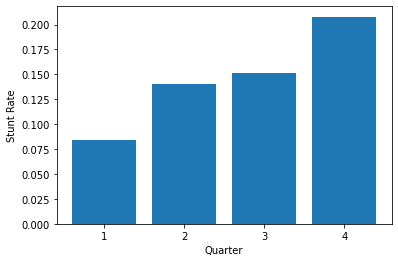

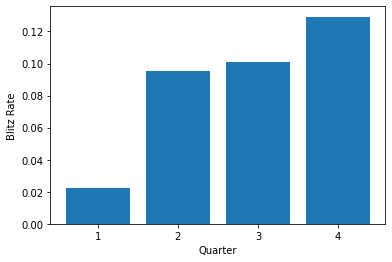

In [93]:
output = when_they_blitz('DAL')

In [132]:
plays = all_stunts['gameplayId'].loc[(all_stunts.stunt_class == 1)]
play_index = random.randint(0,plays.shape[0])
ids = plays.iloc[play_index].split('_')
gameId = int(ids[0])
playId = int(ids[1])
print(gameId)
print(playId)

2021091906
3050


In [164]:
tm = pd.DataFrame(all_stunts.groupby('stunt_class').stunt.count()).reset_index(drop=True)
tm = tm.drop(tm.index[0]).sort_values(['stunt'],ascending=False)
stunt_classes = tm.iloc[0:3].index.values
stunts = all_stunts['gameplayId'].loc[(all_stunts.stunt_class == ????)]
ids = stunts.iloc[play_index].split('_')
gameId = int(ids[0])
playId = int(ids[1])
animate_play(all_weeks,plays,players,pff,gameId,playId).show()
    

In [161]:
poop = pd.read_csv('/kaggle/input/all-stunts/finalplays_with_epa.csv')
poop[(poop.gameId == 2021103100) & (poop.playId == 744)].iloc[0]

Unnamed: 0                                                             7563
...1                                                                   7562
gameId                                                           2021103100
playId                                                                  744
playDescription           (4:00) (Shotgun) S.Darnold pass short left to ...
quarter                                                                   1
down                                                                      3
yardsToGo                                                                17
possessionTeam                                                          CAR
defensiveTeam                                                           ATL
yardlineSide                                                            CAR
yardlineNumber                                                           10
gameClock                                                          04:00:00
preSnapHomeS

In [115]:
animate_play(week1,plays,players,pff,2021090900,137).show()

In [42]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

colors = {
'ARI':"#97233F", 
'ATL':"#A71930", 
'BAL':'#241773', 
'BUF':"#00338D", 
'CAR':"#0085CA", 
'CHI':"#C83803", 
'CIN':"#FB4F14", 
'CLE':"#311D00", 
'DAL':'#003594',
'DEN':"#FB4F14", 
'DET':"#0076B6", 
'GB':"#203731", 
'HOU':"#03202F", 
'IND':"#002C5F", 
'JAX':"#9F792C", 
'KC':"#E31837", 
'LA':"#003594", 
'LAC':"#0080C6", 
'LV':"#000000",
'MIA':"#008E97", 
'MIN':"#4F2683", 
'NE':"#002244", 
'NO':"#D3BC8D", 
'NYG':"#0B2265", 
'NYJ':"#125740", 
'PHI':"#004C54", 
'PIT':"#FFB612", 
'SEA':"#69BE28", 
'SF':"#AA0000",
'TB':'#D50A0A', 
'TEN':"#4B92DB", 
'WAS':"#5A1414", 
'football':'#CBB67C'
}

plays = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/plays.csv')
# week1 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week1.csv')
pff = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/pffScoutingData.csv')
players = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/players.csv')

week1 = pd.read_csv('../input/nfl-big-data-bowl-2023/week1.csv')
week2 = pd.read_csv('../input/nfl-big-data-bowl-2023/week2.csv')
week3 = pd.read_csv('../input/nfl-big-data-bowl-2023/week3.csv')
week4 = pd.read_csv('../input/nfl-big-data-bowl-2023/week4.csv')
week5 = pd.read_csv('../input/nfl-big-data-bowl-2023/week5.csv')
week6 = pd.read_csv('../input/nfl-big-data-bowl-2023/week6.csv')
week7 = pd.read_csv('../input/nfl-big-data-bowl-2023/week7.csv')
week8 = pd.read_csv('../input/nfl-big-data-bowl-2023/week8.csv')
all_weeks = pd.concat([week1,week2,week3,week4,week5,week6,week7,week8])

In [32]:
def animate_play(tracking_df, play_df,players,pffScoutingData, gameId,playId):
       
    selected_play_df = play_df[(play_df.playId==playId)&(play_df.gameId==gameId)].copy()
    
    tracking_players_df = pd.merge(tracking_df,players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()

    # get play General information 
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    first_down_marker = line_of_scrimmage + selected_play_df.yardsToGo.values[0]
    down = selected_play_df.down.values[0]
    quarter = selected_play_df.quarter.values[0]
    gameClock = selected_play_df.gameClock.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field 
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[53.5-5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add line of scrimage 
        data.append(
            go.Scatter(
                x=[line_of_scrimmage,line_of_scrimmage], 
                y=[0,53.5],
                line_dash='dash',
                line_color='blue',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add First down line 
        data.append(
            go.Scatter(
                x=[first_down_marker,first_down_marker], 
                y=[0,53.5],
                line_dash='dash',
                line_color='yellow',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Plot Players
        for team in selected_tracking_df.team.unique():
            plot_df = selected_tracking_df[(selected_tracking_df.team==team)&(selected_tracking_df.frameId==frameId)].copy()
            if team != "football":
                hover_text_array=[]
                for nflId in plot_df.nflId:
                    selected_player_df = plot_df[plot_df.nflId==nflId]
                    hover_text_array.append("nflId:{}<br>displayName:{}<br>Position:{}<br>Role:{}".format(selected_player_df["nflId"].values[0],
                                                                                      selected_player_df["displayName"].values[0],
                                                                                      selected_player_df["pff_positionLinedUp"].values[0],
                                                                                      selected_player_df["pff_role"].values[0]))
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hovertext=hover_text_array,hoverinfo="text"))
            else:
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hoverinfo='none'))
        # add frame to slider
        slider_step = {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"}
        sliders_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=10
    layout = go.Layout(
        autosize=False,
        width=120*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{playDescription}",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]["data"],
        layout= layout,
        frames=frames[1:]
    )
    # Create First Down Markers 
    for y_val in [0,53]:
        fig.add_annotation(
                x=first_down_marker,
                y=y_val,
                text=str(down),
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="black"
                    ),
                align="center",
                bordercolor="black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=1
                )

    return fig